In [ ]:
!pip install transformers --quiet

from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from datetime import datetime
import joblib
from tqdm import tqdm
from transformers import TFBertModel, BertTokenizer
import numpy as np
from tensorflow import keras
from requests import get
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')
from tensorflow.keras.models import load_model
import time
import json
from tensorflow.keras.layers import Dense, Dropout
import os

MODEL_SAVEPATH = "/content/drive/MyDrive/simo/"
TIMENOW = datetime.now().strftime('%d-%m-%y-%H-%M')
lbl_enc = preprocessing.LabelEncoder()
scaler = StandardScaler()
os.makedirs("/content/drive/MyDrive/simo/logs", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/sklearn", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/bert", exist_ok=True)
os.makedirs("/content/drive/MyDrive/simo/logs/stylo", exist_ok=True)


def preprocess(text,stem=False):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)


class Experiment:
  def __init__(self, dataset_path, split_size, target_col, model_savepath=MODEL_SAVEPATH):
    self.dataset_path = dataset_path
    self.split_size = split_size
    self.target_col = target_col
    self.dataset_name = dataset_path.split(".")[-2].split("/")[-1]
    self.model_savepath = model_savepath
    self.nb_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].split(".")[0]


  def load_split_dataset(self, dataset_path, dropna=False, do_split=True, use_scaler=False):
    format = dataset_path.split(".")[-1]
    valid = {"csv", "xlsx", "xls"}
    if format not in valid:
      raise ValueError(f"results: status must be one of {valid}.")
    elif format == "csv":
      dataset = pd.read_csv(dataset_path)
    elif (format == "xlsx" or format == "xls"):
      dataset = pd.read_excel(dataset_path)

    X = dataset.drop(self.target_col, axis=1)
    y = lbl_enc.fit_transform(dataset[self.target_col].values)

    #dropping nans
    if dropna:
      print("DROPPING NAN")
      dataset = dataset.dropna(axis=0, how='any')

    if use_scaler:
      X = scaler.fit_transform(X)

    
    listy = list(lbl_enc.inverse_transform(y))
    print("Dataset class distribution:")
    for i in set(listy):
      print(i, listy.count(i))

    if do_split:
      xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=self.split_size, shuffle=True)
      return xtrain, xvalid, ytrain, yvalid
    else:
      return X, y


  def print_cm(self, yvalid, predicted, target_names=[]): 
    cm = metrics.confusion_matrix(yvalid, predicted)
    disp = metrics.ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(xticks_rotation="vertical")

  def print_report(self, predicted, yvalid, target_names=None):
    report_dict = metrics.classification_report(yvalid, predicted, target_names=[str(x) for x in target_names], output_dict=True)
    report_text = metrics.classification_report(yvalid, predicted, target_names=[str(x) for x in target_names])
    print(report_text)
    self.print_cm(yvalid, predicted, target_names=target_names)
    return report_dict

  
  def load_test_dataset(self, testdataset_path, dropna):
    X, y = self.load_split_dataset(testdataset_path, dropna=dropna, do_split=False)
    target_names = lbl_enc.inverse_transform(list(set(y)))
    return X, y, target_names


class PublicExpertiment(Experiment):
  def __init__(self, dataset_path, split_size, target_col, text_col, model_savepath=MODEL_SAVEPATH, preprocess_dataset=True):
    super().__init__(dataset_path, split_size, target_col, model_savepath)
    self.text_col = text_col
    self.preprocess_dataset = preprocess_dataset


class ScikitExperiment(PublicExpertiment):
  def __init__(self, dataset_path, split_size, target_col, text_col, algo, model_savepath=MODEL_SAVEPATH, preprocess_dataset=True):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     target_col=target_col, 
                     text_col=text_col, 
                     model_savepath=model_savepath, 
                     preprocess_dataset=preprocess_dataset
                     )
    self.algo = algo


  def train(self, dropna=False):
    start = time.time()
    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, dropna=dropna)
    xtrain = xtrain[self.text_col]
    xvalid = xvalid[self.text_col]
    if self.preprocess_dataset:
      print("Preprocessing texts...\n")
      print(f"Before: {xtrain.iloc[0]}")
      xtrain = xtrain.apply(lambda x: preprocess(x))
      xvalid = xvalid.apply(lambda x: preprocess(x))
      print(f"After: {xtrain.iloc[0]}")
      
    clf_pipeline = Pipeline([
     ('ctv', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', self.algo),
    ])
    print(f"Fitting pipeline: {clf_pipeline}")
    clf_pipeline.fit(xtrain, ytrain)
    end = time.time()
    elapsed = round(end - start, 2)
    predicted = clf_pipeline.predict(xvalid)
    report = super().print_report(predicted, yvalid, target_names=lbl_enc.inverse_transform(list(set(yvalid))))

    self.save_model(clf_pipeline)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_path.split("/")[-1], len(xtrain)+len(xvalid), type(self.algo).__name__, elapsed, report)
    return log_dict

  
  def save_model(self, model):
    algo_name = type(self.algo).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":

      print(f"Saving model to {self.model_savepath+experiment_name}.pkl")
      joblib.dump(model, f'{self.model_savepath}{experiment_name}.pkl')
    else:
      print("Model wasn't saved")


  def load_model_and_predict(self, modelpath, X):
    model = joblib.load(modelpath, mmap_mode=None) #sklearn  
    predicted = model.predict(X) 
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path, modelpath, dropna=False):
    start = time.time()
    X, y, target_names = super().load_test_dataset(testdataset_path, dropna=dropna)

    predicted = self.load_model_and_predict(modelpath, X)
    super().print_report(predicted, y, target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))


  def log(self, savepath, datasetname, dataset_len, algo, elapsed, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "algo": algo,
        "elapsed": elapsed,
        "metrics_report": report
    }
    algo_name = type(self.algo).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    with open(f'{savepath}{experiment_name}_log.json', 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", f'{savepath}{experiment_name}_log.json')
    return log_dict


class TFExperiment(PublicExpertiment):
  def __init__(self, dataset_path, split_size, text_col, target_col, preprocess_dataset=True, model_savepath=MODEL_SAVEPATH, bert_pretrained_model='bert-large-uncased', bert_encode_maxlen=60):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     text_col=text_col, 
                     target_col=target_col, 
                     preprocess_dataset=preprocess_dataset, 
                     model_savepath=model_savepath)
    self.bert_pretrained_model = bert_pretrained_model
    self.bert_encode_maxlen = bert_encode_maxlen
  

  def bert_encode(self, data, max_len) :
    bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
    input_ids = [] 
    attention_masks = []
    
    for i in tqdm(range(len(data))):
        encoded = bert_tokenizer.encode_plus(data.iloc[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


  def create_model(self, bert_encode_maxlen, bert_pretrained_model, optimizer, loss, metrics):
    bert_layers = TFBertModel.from_pretrained(bert_pretrained_model)

    input_ids = keras.Input(shape=(bert_encode_maxlen,),dtype='int32',name='input_ids')
    attention_masks = keras.Input(shape=(bert_encode_maxlen,),dtype='int32',name='attention_masks')

    output = bert_layers([input_ids,attention_masks])
    output = output[1]
    net = keras.layers.Dense(32,activation='relu')(output)
    net = keras.layers.Dropout(0.2)(net)
    net = keras.layers.Dense(1,activation='sigmoid')(net)
    outputs = net
    model = keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics])
    
    model.summary()
    return model


  def train(self, bert_encode_maxlen=None, bert_pretrained_model=None, dropna=False, epochs=10, optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics='accuracy', callbacks=[]):
    start = time.time()
    if bert_encode_maxlen is None:
      bert_encode_maxlen = self.bert_encode_maxlen
    if bert_pretrained_model is None:
      bert_pretrained_model = self.bert_pretrained_model

    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, dropna=dropna)
    xtrain = xtrain[self.text_col]
    xvalid = xvalid[self.text_col]
    train_input_ids, train_attention_masks = self.bert_encode(xtrain, bert_encode_maxlen)
    val_input_ids, val_attention_masks = self.bert_encode(xvalid, bert_encode_maxlen)

    model = self.create_model(bert_encode_maxlen, bert_pretrained_model, optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
    [train_input_ids, train_attention_masks],
    ytrain,
    epochs=epochs,
    # validation_data=([val_input_ids, val_attention_masks], y_val),
    batch_size=32, 
    # callbacks=callbacks for now no callbacls
    )
    end = time.time()
    elapsed = round(end - start, 2)

    predicted = model.predict([val_input_ids, val_attention_masks])
    predicted = np.array(list(round(i[0]) for i in predicted))
    report = super().print_report(predicted, yvalid, target_names=lbl_enc.inverse_transform(list(set(yvalid))))

    self.save_model(model)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_path.split("/")[-1], model, len(xtrain)+len(xvalid), elapsed, bert_encode_maxlen, epochs, bert_pretrained_model, optimizer, report)

  
  def save_model(self, model):
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":
      print(f"Saving model to {self.model_savepath+experiment_name}.h5")
      model.save(f'{self.model_savepath}{experiment_name}.h5')
    else:
      print("Model wasn't saved")


  def load_model_and_predict(self, modelpath, X):
    model = load_model(modelpath, custom_objects={'TFBertModel':TFBertModel.from_pretrained(self.bert_pretrained_model)}) 
    predicted = model.predict(X) 
    predicted = np.array(list(round(i[0]) for i in predicted))
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path, modelpath, dropna=False):
    start = time.time()
    X, y, target_names = super().load_test_dataset(testdataset_path, dropna=dropna)
    input_ids, attention_masks = self.bert_encode(X, self.bert_encode_maxlen)

    predicted = self.load_model_and_predict(modelpath, [input_ids, attention_masks])
    super().print_report(predicted, y, target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))


  def log(self, savepath, datasetname, model, dataset_len, elapsed, bert_encode_maxlen, epochs, bert_pretrained_model, optimizer, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "elapsed": elapsed,
        "bert_encode_maxlen": bert_encode_maxlen,
        "epochs": epochs,
        "bert_pretrained_model": bert_pretrained_model,
        "optimizer": str(optimizer),
        "metrics_report": report
    }
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name
    with open(f'{savepath}{experiment_name}_log.json', 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", f'{savepath}{experiment_name}_log.json')
    return log_dict


class StyloExperiment(Experiment):
  def __init__(self, dataset_path, split_size, target_col, model_savepath=MODEL_SAVEPATH):
    super().__init__(dataset_path=dataset_path, 
                     split_size=split_size, 
                     target_col=target_col, 
                     model_savepath=model_savepath)


  def train(self, epochs=10):
    start = time.time()
    xtrain, xvalid, ytrain, yvalid = super().load_split_dataset(self.dataset_path, use_scaler=True)

    nn_parameters = {
      "n_layers": 1,
      "n_units_input": 51,
      "activation": "relu",
      "n_units_l0": 80,
      "dropout_l0": 0.3203504513234906,
      "learning_rate": 0.0014392587661767942,
      "optimizer": "RMSprop"
    }

    model = keras.models.Sequential()
    model.add(
        Dense(
            nn_parameters["n_units_input"], 
            input_dim=xtrain.shape[1],
            activation=nn_parameters["activation"],
          )
    )
    for i in range(nn_parameters["n_layers"]):
      model.add(
          Dense(
            nn_parameters[f"n_units_l{i}"],
            activation=nn_parameters["activation"],
          )
      )
      model.add(
          Dropout(nn_parameters[f"dropout_l{i}"])
      )
    model.add(Dense(1, activation="sigmoid"))

    # We compile our model with a sampled learning rate.
    learning_rate = nn_parameters["learning_rate"]
    optimizer_name = nn_parameters["optimizer"]
    model.compile(
        loss="binary_crossentropy",
        optimizer=getattr(keras.optimizers, optimizer_name)(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    history = model.fit(
        xtrain,
        ytrain,
        batch_size=512, 
        epochs=epochs,
        validation_data=(xvalid, yvalid)
    )
    end = time.time()
    elapsed = round(end - start, 2)

    predicted = model.predict(xvalid)
    predicted = np.array(list(round(i[0]) for i in predicted))
    report = super().print_report(predicted, yvalid, target_names=lbl_enc.inverse_transform(list(set(yvalid))))
    print(lbl_enc.classes_)
    self.save_model(model)
    print("Time elapsed in seconds: ", round(elapsed, 2))
    
    log_dict = self.log(self.model_savepath, self.dataset_path.split("/")[-1], model, len(xtrain)+len(xvalid), elapsed, epochs, nn_parameters, report)

  
  def save_model(self, model):
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name+"_stilometria"
    save_confirmation = input(f"Save model {experiment_name}? (y/n)")
    if save_confirmation == "y":
      print(f"Saving model to {self.model_savepath+experiment_name}.h5")
      model.save(f'{self.model_savepath}{experiment_name}.h5')
    else:
      print("Model wasn't saved")

  def load_model_and_predict(self, modelpath, X):
    model = load_model(modelpath) 
    predicted = model.predict(X) 
    predicted = np.array(list(round(i[0]) for i in predicted))
    return predicted


  def evaluate_on_other_dataset(self, testdataset_path, modelpath, dropna=False):
    start = time.time()
    X, y, target_names = super().load_test_dataset(testdataset_path, dropna=dropna)
    X = scaler.transform(X)

    predicted = self.load_model_and_predict(modelpath, X)
    super().print_report(predicted, y, target_names)
    end = time.time()
    elapsed = round(end - start, 2)
    print("Time elapsed in seconds: ", round(elapsed, 2))


  def log(self, savepath, datasetname, model, dataset_len, elapsed, epochs, nn_parameters, report):
    log_dict = {
        "library_used": type(self).__name__,
        "dataset_name": datasetname,
        "dataset_lenght": dataset_len,
        "elapsed": elapsed,
        "epochs": epochs,
        "nueral_net_parameters": nn_parameters,
        "metrics_report": report
    }
    algo_name = type(model).__name__
    experiment_name = self.nb_name+"__"+self.dataset_name+"__"+algo_name+"_stilometria"
    filepath = f'{savepath}logs/stylo/{experiment_name}_log.json'
    with open(filepath, 'w') as fp:
      json.dump(log_dict, fp)
      print("Log saved to ", filepath)
    return log_dict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset class distribution:
0 35025
1 36179
Epoch 1/5
98/98 [==============================] - 1s 7ms/step - loss: 0.3850 - accuracy: 0.8404 - val_loss: 0.3082 - val_accuracy: 0.8752
Epoch 2/5
98/98 [==============================] - 1s 5ms/step - loss: 0.2793 - accuracy: 0.8911 - val_loss: 0.2702 - val_accuracy: 0.8969
Epoch 3/5
98/98 [==============================] - 1s 6ms/step - loss: 0.2399 - accuracy: 0.9066 - val_loss: 0.2612 - val_accuracy: 0.9010
Epoch 4/5
98/98 [==============================] - 1s 6ms/step - loss: 0.2188 - accuracy: 0.9160 - val_loss: 0.2422 - val_accuracy: 0.9090
Epoch 5/5
98/98 [==============================] - 1s 5ms/step - loss: 0.2032 - accuracy: 0.9216 - val_loss: 0.2381 - val_accuracy: 0.9094
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     10574
           1       0.92      0.90      0.91     10788

    accuracy                           0.91     21362
   macro avg       0.91      0.91      0.91

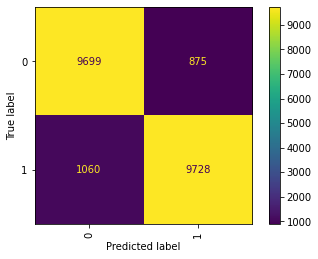

In [ ]:
exp = StyloExperiment("/content/drive/MyDrive/simo/datasets/welfake_stylo.csv", 0.3, target_col="Target")
exp.train(epochs=5)

Dataset class distribution:
male 100
female 99
Preprocessing texts...

Before: What the QWERTY Keyboard and Education Have in Common https://t.co/Bpxrfn2VbW via @ajjuliani
After: qwerty keyboard education common via ajjuliani
Fitting pipeline: Pipeline(steps=[('ctv', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])
              precision    recall  f1-score   support

      female       0.82      0.93      0.87        29
        male       0.93      0.81      0.86        31

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Save model experiment_classes__df_gender200__MultinomialNB? (y/n)n
Model wasn't saved
Time elapsed in seconds:  2.47
Log saved to  /content/drive/MyDrive/simo/experiment_classes__df_gender200__MultinomialNB_log.json


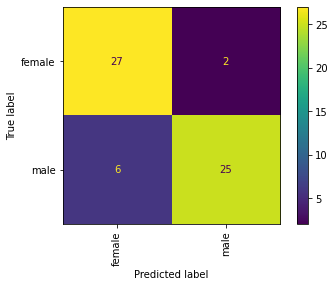

In [ ]:
# exp = ScikitExperiment('/content/drive/MyDrive/simo/datasets/df_gender200.csv', 0.1, MultinomialNB(), text_col="texts", target_col="gender")
# exp = ScikitExperiment('/content/drive/MyDrive/simo/datasets/df_gender200.csv', 0.3, MultinomialNB(), text_col="texts", target_col="gender")
exp = ScikitExperiment('/content/drive/MyDrive/simo/datasets/df_gender200.csv', split_size=0.3, text_col="texts", target_col="gender", algo=MultinomialNB())
log = exp.train()

Dataset class distribution:
male 100
female 99


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

  0%|          | 0/139 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 60/60 [00:00<00:00, 1553.89it/s]


Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

      female       0.48      1.00      0.65        29
        male       0.00      0.00      0.00        31

    accuracy                           0.48        60
   macro avg       0.24      0.50      0.33        60
weighted avg       0.23      0.48      0.31        60

Save model experiment_classes__df_gender200__Functional? (y/n)n
Model wasn't saved
Time elapsed in seconds:  95.7
Log saved to  /content/drive/MyDrive/simo/experiment_classes__df_gender200__Functional_log.json


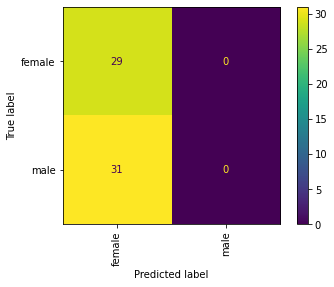

In [ ]:
bertexp = TFExperiment('/content/drive/MyDrive/simo/datasets/df_gender200.csv', 0.3, text_col="texts", target_col="gender")
bertexp.train(epochs=1)

Preprocessing texts...

Dataset class distribution:
female 99
male 100


  0%|          | 0/199 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 199/199 [00:00<00:00, 2342.29it/s]
Some laye

              precision    recall  f1-score   support

      female       0.78      0.92      0.84        99
        male       0.90      0.74      0.81       100

    accuracy                           0.83       199
   macro avg       0.84      0.83      0.83       199
weighted avg       0.84      0.83      0.83       199

Time elapsed in seconds:  59.25


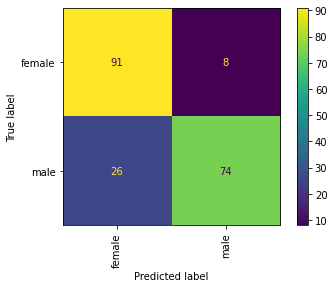

In [ ]:
bertexp.evaluate_on_other_dataset('/content/drive/MyDrive/simo/datasets/df_gender200.csv', '/content/drive/MyDrive/simo/experiment_classes__df_gender200__Functional.h5')